In [4]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import umap
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import torch
print(torch.cuda.is_available())  # should return True
from joblib import Parallel, delayed
import numpy as np



C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\bajim\miniconda3\envs\torch_env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\bajim\miniconda3\envs\torch_env\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File

True


In [5]:
genome = pd.read_csv("../data/ml-25m/genome-scores.csv")
genome_tags = pd.read_csv("../data/ml-25m/genome-tags.csv")
movies = pd.read_csv("../data/ml-25m/movies.csv")
tags = pd.read_csv("../data/ml-25m/tags.csv")
ratings = pd.read_csv("../data/ml-25m/ratings.csv")
links = pd.read_csv("../data/ml-25m/links.csv")

# Model 1.1

We want to cluster users who liked similar movies, so we need to create a user-item matrix where rows are users and columns are movies, and the values are ratings. Then we can apply clustering algorithms on this matrix.

In [6]:
# little helper function to get genre ratings, important when we want to cluster users by their movie preferences. returns a DataFrame where each column corresponds
# to a genre and each row corresponds to a user, with the values being the average ratings for that genre that the user has given to movies in that genre.
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre)]
        genre_ratings[genre] = ratings[ratings['movieId'].isin(genre_movies['movieId'])].groupby('userId')['rating'].mean()
    genre_ratings = genre_ratings.fillna(0)
    genre_ratings.columns = column_names
    return genre_ratings

In [9]:
# get all genres from the movies DataFrame
genres = set()
for genre_list in movies['genres'].str.split('|'):
    genres.update(genre_list)
# create the column names for the genre ratings DataFrame avg_{genre}_rating for each genre
genres = sorted(genres)
genre_columns = {genre: f'avg_{genre.lower()}_rating' for genre in genres}

genre_ratings = get_genre_ratings(ratings, movies, genre_columns, genres)
genre_ratings.head()

C:\Users\bajim\AppData\Local\Temp\ipykernel_21324\1366261861.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  genre_movies = movies[movies['genres'].str.contains(genre)]


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
3,3.500000,3.640719,3.689394,3.980000,3.708333,3.454545,3.886364,3.166667,3.890086,3.737179,4.300000,3.544444,3.734568,3.583333,3.891667,3.533333,3.696429,3.692469,3.692308,3.750000
84,3.833333,2.963415,3.100000,3.578947,3.550000,3.397059,3.562500,3.447368,3.575893,3.722222,3.642857,3.285714,3.166667,3.444444,3.532258,3.484127,3.261364,3.491228,3.346154,3.750000
181,3.250000,1.782700,1.702899,0.866667,1.090909,1.563679,1.853659,1.300000,1.941304,1.661290,2.400000,2.080128,1.269231,0.928571,2.095588,1.468254,1.962963,1.934211,1.843750,2.045455
187,5.000000,3.935961,3.892361,3.742991,3.529851,3.703767,4.025907,4.220588,4.075221,3.737113,3.750000,3.746964,3.950000,3.785714,3.963710,3.734483,3.977528,3.963190,4.140625,3.681818
208,5.000000,4.096154,4.065217,3.700000,3.700000,4.319444,4.455882,0.000000,4.321429,3.892857,0.000000,4.500000,3.740000,4.000000,4.666667,4.285714,4.325000,4.260417,4.000000,3.500000


C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


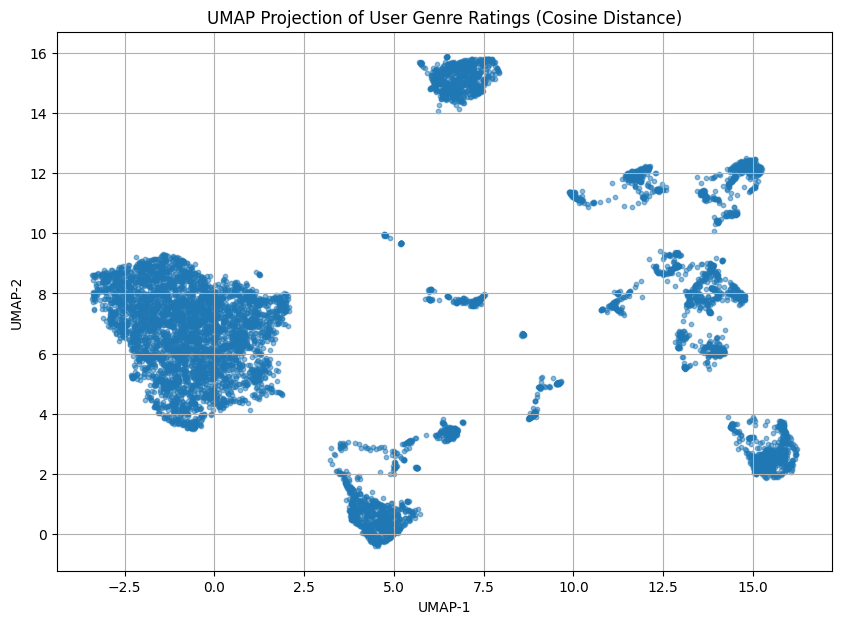

C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


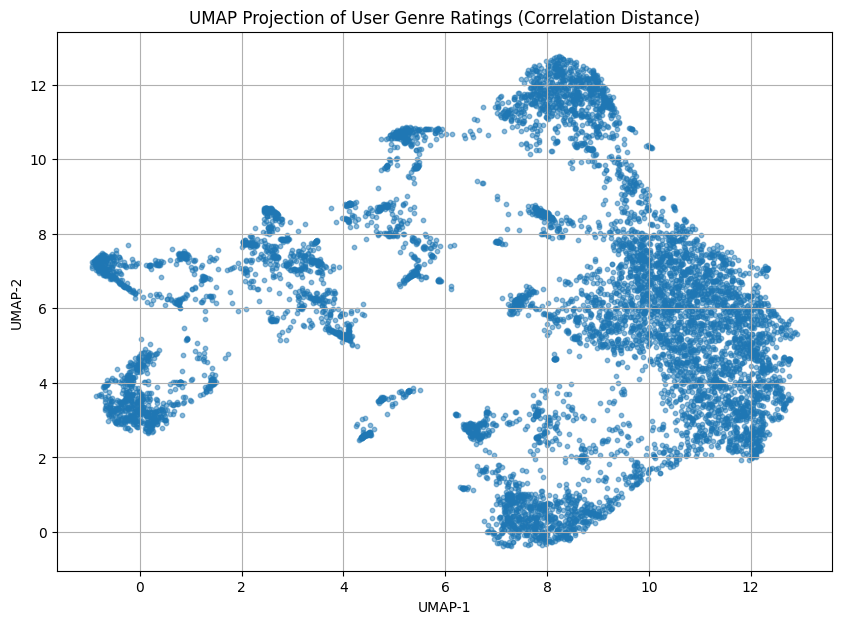

C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


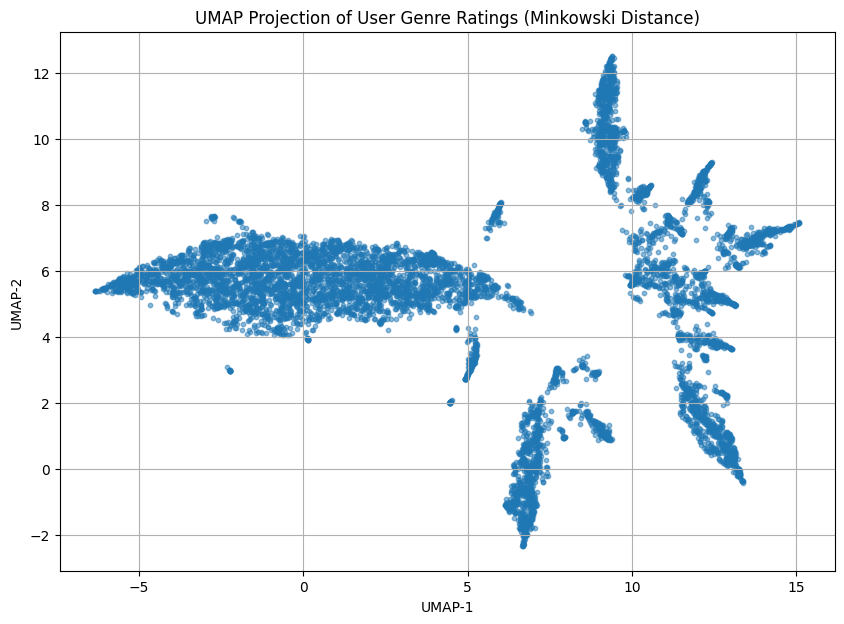

C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\pynndescent\pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(


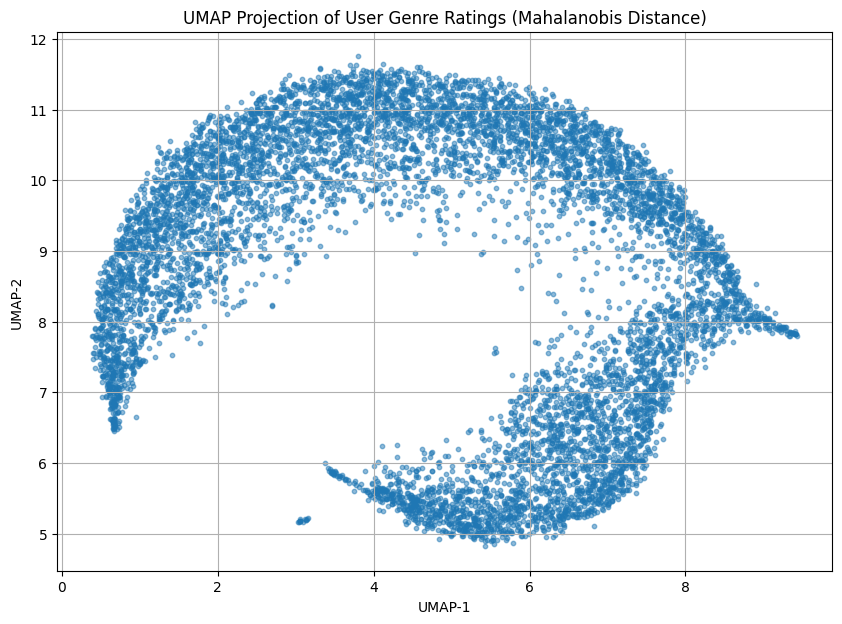

In [10]:
# plot the UMAP embedding of the genre ratings with different distances
distances = ["cosine", "correlation", "minkowski", "mahalanobis"]
for metric in distances:
    reducer = umap.UMAP(metric=metric, random_state=42)
    embedding = reducer.fit_transform(genre_ratings)

    plt.figure(figsize=(10, 7))
    plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5, s=10)
    plt.title(f"UMAP Projection of User Genre Ratings ({metric.capitalize()} Distance)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True)
    plt.show()


C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bajim\miniconda3\envs\torch_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


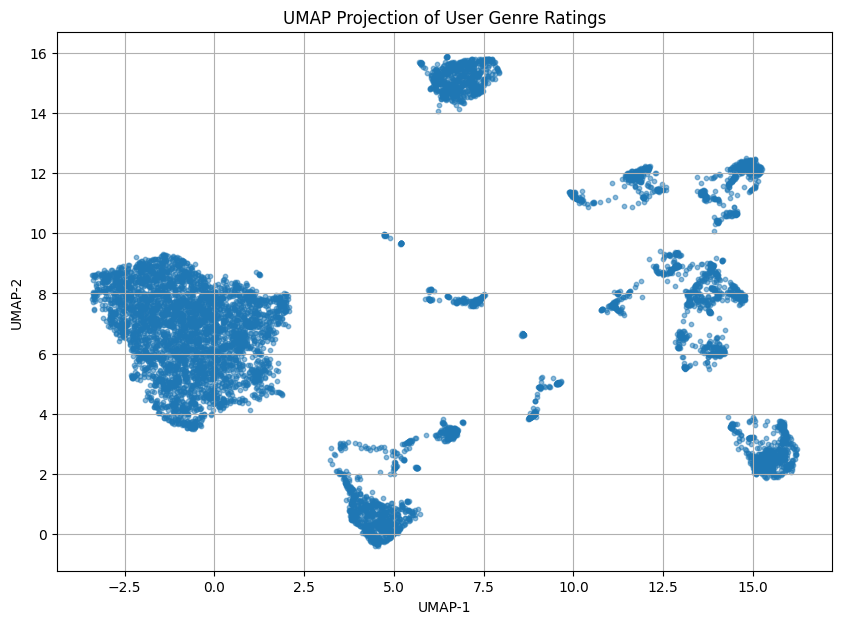

In [11]:
reducer = umap.UMAP(metric="cosine", random_state=42)
embedding = reducer.fit_transform(genre_ratings)


plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5, s=10)
plt.title("UMAP Projection of User Genre Ratings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


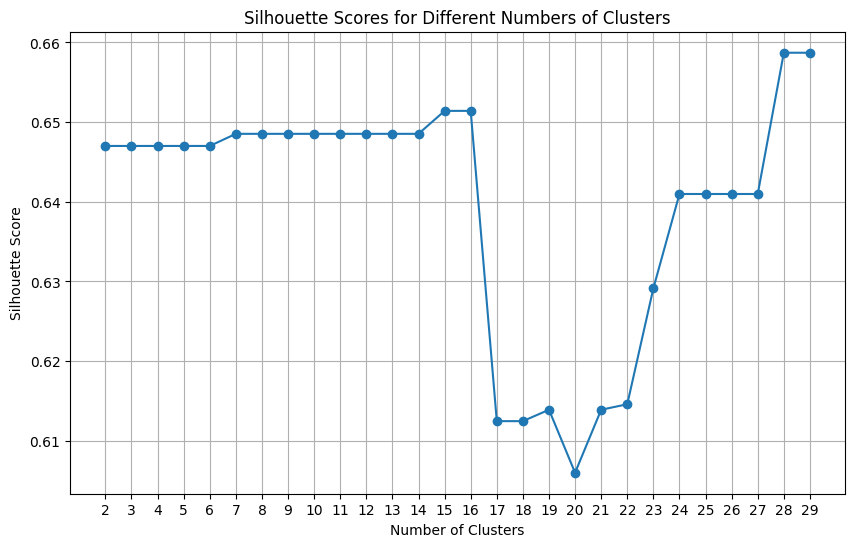

In [12]:
# plot silhouette scores for different numbers of clusters on the UMAP embedding of the genre ratings (DBSCAN)
silhouette_scores = []
for n_clusters in range(2, 30):
    dbscan = DBSCAN(eps=0.5, min_samples=n_clusters)
    labels = dbscan.fit_predict(embedding)
    if len(set(labels)) > 1:  # at least two clusters are needed for silhouette score
        score = silhouette_score(embedding, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # invalid score for single cluster
plt.figure(figsize=(10, 6))
plt.plot(range(2, 30), silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, 30))
plt.grid(True)


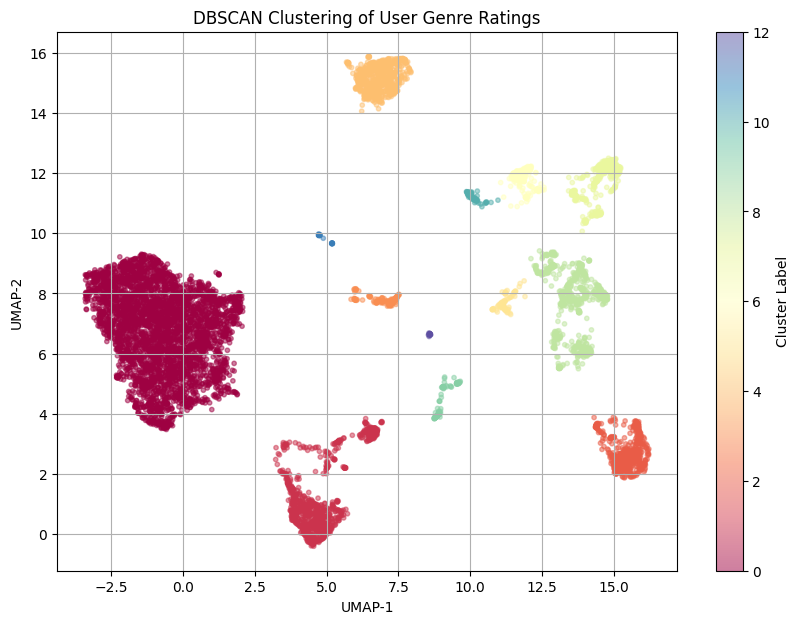

In [13]:
# apply DBSCAN clustering on the UMAP embedding of the genre ratings
dbscan = DBSCAN(eps=0.5, min_samples=7)
labels = dbscan.fit_predict(embedding)

# Add cluster labels to the genre ratings DataFrame
genre_ratings['cluster'] = labels

# plot the clusters on the UMAP embedding
plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', alpha=0.5, s=10)
plt.title("DBSCAN Clustering of User Genre Ratings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()


In [14]:
def recommend_movies_for_user(user_id, n_recommendations=10):
    # Ensure index is int
    genre_ratings.index = genre_ratings.index.astype(int)

    if user_id not in genre_ratings.index:
        raise ValueError(f"user_id {user_id} not in genre_ratings index")

    # Get the user's genre profile
    user_ratings = genre_ratings.loc[user_id]
    user_cluster = user_ratings['cluster']

    # Get all users in the same cluster
    similar_users = genre_ratings[genre_ratings['cluster'] == user_cluster]

    # Calculate similarity (exclude 'cluster' column)
    similarity_scores = cosine_similarity(
        [user_ratings.drop('cluster')],
        similar_users.drop(columns='cluster')
    )[0]

    # Top N similar users (excluding self)
    similar_indices = similarity_scores.argsort()[::-1]
    similar_user_ids = similar_users.iloc[similar_indices].index.tolist()

    # Build recommendations
    recommended_movies = []
    for uid in similar_user_ids:
        if uid == user_id:
            continue
        watched = ratings[ratings['userId'] == uid]['movieId'].unique()
        recommended_movies.extend(watched)

        if len(recommended_movies) >= n_recommendations * 2:
            break

    # Deduplicate and remove already seen
    seen = ratings[ratings['userId'] == user_id]['movieId'].unique()
    recommended_movies = list(set(recommended_movies) - set(seen))

    return movies[movies['movieId'].isin(recommended_movies)].head(n_recommendations)


In [15]:
def recommend_movies_for_user_test(user_id, n_recommendations=10, seen_movies=None):
    genre_ratings.index = genre_ratings.index.astype(int)

    if user_id not in genre_ratings.index:
        return pd.DataFrame(columns=['movieId', 'title', 'genres'])

    user_ratings = genre_ratings.loc[user_id]
    user_cluster = user_ratings['cluster']
    similar_users = genre_ratings[genre_ratings['cluster'] == user_cluster]

    similarity_scores = cosine_similarity(
        [user_ratings.drop('cluster')],
        similar_users.drop(columns='cluster')
    )[0]

    similar_indices = similarity_scores.argsort()[::-1]
    similar_user_ids = similar_users.iloc[similar_indices].index.tolist()

    recommended_movies = []
    for uid in similar_user_ids:
        if uid == user_id:
            continue
        watched = ratings[ratings['userId'] == uid]['movieId'].unique()
        recommended_movies.extend(watched)

        if len(recommended_movies) >= n_recommendations * 2:
            break

    if seen_movies is not None:
        recommended_movies = list(set(recommended_movies) - set(seen_movies))

    return movies[movies['movieId'].isin(recommended_movies)].head(n_recommendations)


In [16]:
# Example usage
k = 10
recommended_movies = recommend_movies_for_user(3, n_recommendations=k)
print(recommended_movies[['movieId', 'title', 'genres']])

    movieId                           title                         genres
2         3         Grumpier Old Men (1995)                 Comedy|Romance
5         6                     Heat (1995)          Action|Crime|Thriller
6         7                  Sabrina (1995)                 Comedy|Romance
9        10                GoldenEye (1995)      Action|Adventure|Thriller
10       11  American President, The (1995)           Comedy|Drama|Romance
15       16                   Casino (1995)                    Crime|Drama
17       18               Four Rooms (1995)                         Comedy
46       47     Seven (a.k.a. Se7en) (1995)               Mystery|Thriller
69       70      From Dusk Till Dawn (1996)  Action|Comedy|Horror|Thriller
75       76                Screamers (1995)         Action|Sci-Fi|Thriller


In [20]:
def train_test_user_split(ratings, test_size=0.2):
    train_data = []
    test_data = []

    for user_id, group in ratings.groupby('userId'):
        if len(group) < 5:
            continue  # skip users with very few ratings
        train, test = train_test_split(group, test_size=test_size, random_state=42)
        train_data.append(train)
        test_data.append(test)

    return pd.concat(train_data), pd.concat(test_data)

train_ratings, test_ratings = train_test_user_split(ratings)

In [23]:
print(f"Train ratings: {len(train_ratings)} rows, Test ratings: {len(test_ratings)} rows")
test_ratings.head()
# get length of unique users in the test set
print(f"Unique users in test set: {len(test_ratings['userId'].unique())}")

Train ratings: 19936012 rows, Test ratings: 5064083 rows
Unique users in test set: 162541


In [21]:
def evaluate_user(user_id, k=10):
    # Get ground truth: movies the user watched in the test set
    actual_movies = set(
        test_ratings[test_ratings['userId'] == user_id]['movieId']
        .dropna().astype('int64').tolist()
    )
    if not actual_movies:
        print(f"No test ratings for user {user_id}")
        return

    # Get recommendations
    recommended_df = recommend_movies_for_user_test(user_id, n_recommendations=k)
    recommended_movies = recommended_df['movieId'].dropna().astype('int64').tolist()
    if not recommended_movies:
        print(f"No recommendations for user {user_id}")
        return

    recommended_set = set(recommended_movies)

    # Precision@k
    true_positives = len(recommended_set & actual_movies)
    precision = true_positives / k

    # Recall@k
    recall = true_positives / len(actual_movies)

    # F1@k
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0

    # Hit@k
    hit = 1.0 if true_positives > 0 else 0.0

    # MRR@k
    reciprocal_rank = 0.0
    for rank, movie_id in enumerate(recommended_movies, start=1):
        if movie_id in actual_movies:
            reciprocal_rank = 1.0 / rank
            break

    # NDCG@k
    dcg = sum([1.0 / np.log2(i + 2) for i, movie_id in enumerate(recommended_movies) if movie_id in actual_movies])
    idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(actual_movies), k))])
    ndcg = dcg / idcg if idcg > 0 else 0.0

    print(f"User {user_id} Evaluation @ Top-{k}")
    print(f"Precision@{k}: {precision:.4f}")
    print(f"Recall@{k}: {recall:.4f}")
    print(f"F1@{k}: {f1:.4f}")
    print(f"Hit@{k}: {hit:.4f}")
    print(f"MRR@{k}: {reciprocal_rank:.4f}")
    print(f"NDCG@{k}: {ndcg:.4f}")


In [22]:
evaluate_user(3, 10)

User 3 Evaluation @ Top-10
Precision@10: 0.1000
Recall@10: 0.0076
F1@10: 0.0141
Hit@10: 1.0000
MRR@10: 0.1111
NDCG@10: 0.0663


In [24]:
def evaluate_recommendation_model(test_ratings, k=10):
    precisions = []
    recalls = []
    users_evaluated = 0

    for user_id in test_ratings['userId'].unique():
        try:
            # Ground truth: movies the user rated in test set
            actual_movies = set(
                test_ratings[test_ratings['userId'] == user_id]['movieId']
                .dropna()
                .astype('int64')
                .tolist()
            )

            if not actual_movies:
                continue

            # Predicted: top-k recommendations
            recommended_df = recommend_movies_for_user(user_id, n_recommendations=k)
            predicted_movies = set(recommended_df['movieId'].dropna().astype('int64').tolist())

            if not predicted_movies:
                continue

            true_positives = len(predicted_movies & actual_movies)
            precision = true_positives / len(predicted_movies)
            recall = true_positives / len(actual_movies)

            precisions.append(precision)
            recalls.append(recall)
            users_evaluated += 1
        except Exception as e:
            continue

    if users_evaluated == 0:
        print("No users evaluated.")
        return 0.0, 0.0

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)

    print(f"Evaluated {users_evaluated} users.")
    print(f"Average Precision@{k}: {avg_precision:.4f}")
    print(f"Average Recall@{k}: {avg_recall:.4f}")

    return avg_precision, avg_recall


In [128]:
evaluate_recommendation_model(test_ratings, k=10)


User 1: user_id 1 not in genre_ratings index
User 2: user_id 2 not in genre_ratings index
User 4: user_id 4 not in genre_ratings index
User 5: user_id 5 not in genre_ratings index
User 6: user_id 6 not in genre_ratings index
User 7: user_id 7 not in genre_ratings index
User 8: user_id 8 not in genre_ratings index
User 9: user_id 9 not in genre_ratings index
User 10: user_id 10 not in genre_ratings index
User 11: user_id 11 not in genre_ratings index
User 12: user_id 12 not in genre_ratings index
User 13: user_id 13 not in genre_ratings index
User 14: user_id 14 not in genre_ratings index
User 15: user_id 15 not in genre_ratings index
User 16: user_id 16 not in genre_ratings index
User 17: user_id 17 not in genre_ratings index
User 18: user_id 18 not in genre_ratings index
User 19: user_id 19 not in genre_ratings index
User 20: user_id 20 not in genre_ratings index
User 21: user_id 21 not in genre_ratings index
User 22: user_id 22 not in genre_ratings index
User 23: user_id 23 not in ge

KeyboardInterrupt: 

In [25]:
from tqdm import tqdm
import torch
import numpy as np

def evaluate_recommendation_model_gpu_extended(test_ratings, k=10):
    precisions = []
    recalls = []
    f1s = []
    hit_rates = []
    mrrs = []
    ndcgs = []
    recommended_items_set = set()
    users_evaluated = 0

    user_ids = test_ratings['userId'].unique()

    for user_id in tqdm(user_ids, desc=f"Evaluating users @ top-{k}"):
        try:
            # Ground truth
            actual_movies = (
                test_ratings[test_ratings['userId'] == user_id]['movieId']
                .unique()
                .astype('int64')
            )
            if len(actual_movies) == 0:
                continue
            actual_movies_tensor = torch.tensor(actual_movies, dtype=torch.long, device='cuda')

            # Recommendations
            recommended_df = recommend_movies_for_user_test(user_id, n_recommendations=k)
            recommended_movies = np.array(recommended_df['movieId'], dtype='int64')

            if recommended_movies.size == 0:
                continue
            recommended_tensor = torch.tensor(recommended_movies, dtype=torch.long, device='cuda')

            true_positives_mask = torch.isin(recommended_tensor, actual_movies_tensor)
            true_positives = true_positives_mask.sum().item()

            precision = true_positives / len(recommended_tensor)
            recall = true_positives / len(actual_movies_tensor)
            precisions.append(precision)
            recalls.append(recall)

            # F1
            if precision + recall > 0:
                f1 = 2 * precision * recall / (precision + recall)
                f1s.append(f1)

            # Hit Rate
            hit = 1.0 if true_positives > 0 else 0.0
            hit_rates.append(hit)

            # MRR
            reciprocal_rank = 0.0
            for rank, movie_id in enumerate(recommended_tensor.tolist(), start=1):
                if movie_id in actual_movies:
                    reciprocal_rank = 1.0 / rank
                    break
            mrrs.append(reciprocal_rank)

            # NDCG
            dcg = sum([1.0 / np.log2(i + 2) for i, matched in enumerate(true_positives_mask.tolist()) if matched])
            idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(actual_movies), k))])
            ndcg = dcg / idcg if idcg > 0 else 0.0
            ndcgs.append(ndcg)

            # Coverage tracking
            recommended_items_set.update(recommended_movies.tolist())

            users_evaluated += 1

        except Exception:
            continue

    if users_evaluated == 0:
        print("No users evaluated.")
        return {}

    metrics = {
        "Precision@k": sum(precisions) / users_evaluated,
        "Recall@k": sum(recalls) / users_evaluated,
        "F1@k": sum(f1s) / users_evaluated,
        "HitRate@k": sum(hit_rates) / users_evaluated,
        "MRR@k": sum(mrrs) / users_evaluated,
        "NDCG@k": sum(ndcgs) / users_evaluated,
        "User Coverage": users_evaluated / len(user_ids),
        "Item Coverage": len(recommended_items_set),
    }

    metrics_df = pd.DataFrame([metrics])
    return metrics_df


| **Metric**        | **In the context of movie predictions**                                                                                                                                 |
| ----------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Precision\@k**  | Of the top-k movies recommended to a user, **how many were actually watched** by the user in the test set? Measures how many recommendations were **correct**.          |
| **Recall\@k**     | Of the movies a user actually watched in the test set, **how many were found in the top-k recommendations**? Measures how well the system **recovers relevant movies**. |
| **F1\@k**         | The **harmonic mean of precision and recall** — balances how accurate and how complete the recommendations are. Useful when both are important.                         |
| **Hit Rate\@k**   | Did the top-k recommendation list for a user **include at least one movie** they actually watched in the test set? A simple "got one right or not" measure.             |
| **NDCG\@k**       | Do the movies a user actually watched in the test set appear **early in the recommendation list**? Rewards correct predictions near the top of the list more heavily.   |
| **Coverage**      | Out of all movies in your database, **how many different ones were ever recommended** to users? Measures how much of the movie catalog your system actually utilizes.   |
| **User coverage** | Out of all users in the test set, **how many received at least one recommendation** (i.e., didn’t fail silently)? Helps identify coverage holes like cold-start users.  |


In [26]:
evaluate_recommendation_model_gpu_extended(test_ratings, k=10)

Evaluating users @ top-10: 100%|██████████| 162541/162541 [14:28<00:00, 187.05it/s]


,Precision@k,Recall@k,F1@k,HitRate@k,MRR@k,NDCG@k,User Coverage,Item Coverage
0,0.061857,0.013901,0.018502,0.446878,0.178512,0.066638,0.049163,1584


In [27]:
user_id = 84
print("Recommended:")
print(recommend_movies_for_user(user_id)['movieId'].tolist())
print("Actual:")
print(test_ratings[test_ratings['userId'] == user_id]['movieId'].tolist())

Recommended:
[1, 2, 6, 10, 16, 34, 36, 50, 70, 95]
Actual:
[7361, 1199, 71823, 1907, 90439, 60684, 924, 307, 81845, 72249, 110200, 59602, 81191, 1258, 2792, 56782, 1230, 40597, 40629, 27743, 223, 6947, 1302, 8783, 142488, 6291, 127164, 69604, 26662, 27788, 38992, 2959, 8977, 60950, 110387, 106782, 79132, 199, 1968, 27904, 2858, 3148, 2791, 44191, 515, 43415, 33493, 158972, 912, 3910, 60069, 137337, 80463, 5956, 5878, 293, 136020, 3362, 3481, 2028, 26222, 5995, 46578]


In [28]:
user_id = 3
print("Recommended:")
print(recommend_movies_for_user(user_id)['movieId'].tolist())
print("Actual:")
print(test_ratings[test_ratings['userId'] == user_id]['movieId'].tolist())

Recommended:
[3, 6, 7, 10, 11, 16, 18, 47, 70, 76]
Actual:
[5816, 8371, 3977, 135536, 94677, 4369, 6711, 7458, 3300, 6378, 5218, 3996, 95875, 122896, 4344, 139385, 3091, 4366, 67923, 6323, 59369, 3484, 99112, 108945, 112370, 110407, 1882, 112171, 6287, 3755, 4979, 296, 4995, 8666, 4874, 1198, 109578, 176371, 5479, 3994, 130634, 122918, 27134, 6365, 1748, 103810, 48516, 27728, 30825, 4034, 84152, 3535, 159093, 32, 8798, 2571, 31696, 6482, 3452, 68319, 8874, 37386, 8984, 73017, 1196, 67255, 116897, 1270, 179819, 5378, 97923, 50872, 117529, 54286, 168612, 2641, 49274, 1584, 164179, 70286, 1217, 68157, 122912, 173, 8370, 71535, 46335, 4148, 7293, 37727, 34150, 3744, 166528, 151763, 71156, 122900, 5952, 72011, 1222, 5502, 6281, 1909, 4367, 122886, 8810, 7438, 6283, 41566, 912, 33166, 68358, 87430, 104841, 3999, 3578, 148855, 5225, 3471, 95441, 3156, 187541, 82202, 7154, 102880, 2105, 104243, 27773, 107348, 593, 79695, 60760, 41569]
